# LightGBM Using Serverless Functions

```mlrun``` is an open-source Python package that provides a framework for running machine learning tasks transparently in multiple, scalable, runtime environments.  ```mlrun``` provides tracking of code, metadata, inputs, outputs and the results of machine learning pipelines. 

In this notebook we'll take a look at using ```mlrun```, ```nuclio``` and KubeFlow to assemble a data acquisition and model training pipeline and deploy it as a nuclio serverless function with an API endpoint for testing.  The focus here is on how all the components interact, and less on the boosting model and its optimization for the Higgs dataset.

[The key takeaways of this notebook are]
* 1
* 2
* 3


1. [Setup](#Setup)
2. [Nuclio code section](#nuclio-code-section)
     * [nuclio's ignore notation](#nuclio's%20_**ignore**_%20notation)
     * [function dependencies](#function-dependencies)
     * [utiltiy functions](#utilities)
3. [Pipeline methods](#pipeline-methods)
     * [acquire](#acquire)
     * [split](#split)
     * [train](#train)
     * [test](#test)
     * [importance](#importance)
4. [Testing locally](#testing)
5. [Create a deployment image](#image)
6. [Create a KubeFlow Pipeline](#pipeline)
7. [Compile the pipeline](#compile-the-pipeline)

## Setup

The following will reinstall the latest development version of ```mlrun```:

In [1]:
# !pip uninstall -y mlrun
# !pip install git+https://github.com/mlrun/mlrun.git@development

Install the KubeFlow pipelines package ```kfp```. For more information see the **[KubeFlow documentation on nuclio](https://www.kubeflow.org/docs/components/misc/nuclio/)** and  **[Kubeflow pipelines and nuclio](https://github.com/kubeflow/pipelines/tree/master/components/nuclio)**. For logging the estimated machine learning models we'll use ```joblib```'s [```dump``` and ```load```](https://joblib.readthedocs.io/en/latest/persistence.html#persistence).

In [2]:
# !pip install -U kfp joblib seaborn

<a id='nuclio-code-section'></a>
# Nuclio code section

### nuclio's _**ignore**_ notation

You'll write all the code that gets packaged for execution between the tags ```# nuclio: ignore```, meaning ignore all the code here and above, and ```# nuclio: end-code```, meaning ignore everything after this annotation.  Methods in this code section can be called separately if designed as such (```acquire```, ```split```, ```train```, ```test```), or as you'll discover below, they are most often "chained" together to form a pipeline where the output of one stage serves as the input to the next. The **[docs](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** also suggest another approach: we can use ```# nuclio: start``` at the first relevant code cell instead of marking all the cells above with ```# nuclio: ignore```.

See the **[nuclio-jupyter](https://github.com/nuclio/nuclio-jupyter)** repo for further information on these and many other **[nuclio magic commands](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** that make it easy to transform a Jupyter notebook environment into a platform for developing production-quality, machine learning systems.

The ```nuclio-jupyter``` package provides methods for automatically generating and deploying nuclio serverless functions from code, repositories or Jupyter notebooks. **_If you have never run nuclio functions in your notebooks, please uncomment and run the following_**: ```!pip install nuclio-jupyter```

The following two lines _**should be in the same cell**_ and mark the start of your mchine learning coding section:

In [3]:
# nuclio: ignore
import nuclio 

<a id='function-dependencies'></a>
### function dependencies

The installs made in the section **[Setup](#Setup)** covered the Jupyter environment within which this notebook runs.  However, we need to ensure that all the dependencies our nuclio function relies upon (such as ```matplotlib```, ```sklearn```, ```lightgbm```), will be available when that code is wrapped up into a nuclio function _**on some presently unknown runtime**_.   Within the nuclio code section we can ensure these dependencies get built into the function with the ```%nuclio cmd``` magic command.

In [4]:
%nuclio cmd -c pip install -U matplotlib seaborn sklearn lightgbm kfp joblib pyarrow

We'll use a standard base image here, however the build step can be shortened by preparing images with pre-installed packages.

In [5]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


In [6]:
from io import BytesIO
from os import path, makedirs
from pathlib import Path
from urllib.request import urlretrieve
from typing import IO, AnyStr, TypeVar, Union

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import numpy as np

from mlrun.artifacts import ChartArtifact, TableArtifact, PlotArtifact
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

<a id='utilities'></a>
### utility functions



In [7]:
def get_context_table(ctxtable: MLClientCtx):
    """Get table from context.
    
    Convenience function to retrieve a table via a blob.
    
    :param ctxtable: The table saved in the context, 
            which needs to be deserialized.
        
    In this demonstration tables are stored in parquet format and passed
    between steps as blobs.  We could also pass folder or file names
    in the context, which may be faster.
    """
    blob = BytesIO(ctxtable.get())
    return pd.read_parquet(blob, engine='pyarrow')

In [8]:
def log_context_table(
    context: MLClientCtx,
    target: str, 
    name: str,
    table: pd.DataFrame
) -> None:
    """Log a table through the context.
    
    The table is written as a parquet file, and its target
    path is saved in the context.
    
    :param context: The context.
    :param target: Location (folder) of our DataItem.
    :param name: Name of the object in the context.
    :param table: The object we wish to store.
    """
    context.logger.info(f'writing {name}')
    pq.write_table(
        pa.Table.from_pandas(table),
        path.join(target, name))    
    context.log_artifact(name, target_path=path.join(target, name))

<a id=pipeline-methods></a>
### pipeline methods

These are the methods that will be chained together in a pipeline consisting of 4 steps: ```acquire```, ```split```, ```train```, ```test```.  

#### ```acquire```

In the first step, we retrieve data in the form of a gzip archive from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.  The file is saved as a parquet file and its location made available to the next step in the pipeline.



In [9]:
def acquire(
    context: MLClientCtx,
    archive_url: Union[str, Path, IO[AnyStr]],
    name: str = 'original',
    target_path: str = 'content',
    chunksize: int = 10_000
) -> None:
    """Open a file/object archive and save as a parquet file.
    
    Args:
    :param context: The context.
    :param archive_url: Any valid string path consistent with the path variable
            of pandas.read_csv. Includes, strings as file paths, as urls, 
            pathlib.Path objects, etc...
    :param header: Column names.
    :param target_path: Destination folder of table.
    :param chunksize: (default=0). Row size retrieved per iteration. If set
            will override any chunksize parameter in the read_csv_args
            parameter dict.
    :param kwargs:  A dict of parameters passed to pandas.read_csv and
            pyarrow.parquet.write_table. 
    """
    makedirs(target_path, exist_ok=True)
    context.logger.info('verified directories')
   
    # validate file name
    if not name.endswith('.parquet'):
        name += '.parquet'
    dest_path = path.join(target_path , name)
    
    # read and save
    context.logger.info(f'reading chunks from {archive_url}')
    for chunk in pd.read_csv(archive_url, chunksize=chunksize):
        pq.write_table(pa.Table.from_pandas(chunk), dest_path)    
    
    context.logger.info(f'saved table to {target_path}/{name}.parquet')

#### ```split```

In this function we generate labels and split into train-validation-test sets. The split tables are saved and logged.

In another project, this step may involve all of the data preprocessing steps like cleaning, resizing and augmenting images, prefiltering, or each stage in the preprocessing pipeline mayu have its own function.

In [10]:
def split(context: MLClientCtx,
          target_path: str = '',
          src: str = 'original',
          test_size: float = 0.1,
          train_val_split: float = 0.75,
          random_state: int = 1,
          sample: int = -1
) -> None:
    """Split raw data into train, validation and test sets.
    
    The file loaded at this stage is the raw data file that has been
    downloaded in a previous step (as a parquet file).  Here it is read
    and split into train, validation and test sets. The context is 
    updated with the target_path.
    
    context: The `context`.
    :param target: Data storage location.
    :param src: (default 'original'). Location of original parquet file.
    :param test_size: (defaults=0.1) Set test set size, and leave the
            remainder for the second split into train and validation sets.
    :param train_val_split: (defaults=0.75) Once the test set has been
            removed the training set gets this proportion.
    :param random_state: (default 1). Seed used by the scikit-learn random
            number generator in the method train_test_split.
    :param sample: (default -1, all rows). Selects the first n rows, or
            select a sample. Check the balance of resulting sets if
            using the random sample option. Use this feature to explore the
            system or for debugging.
            
    Outputs
        The following outputs are saved at the target path:
        xtrain, ytrain (Tuple[pd.DataFrame, pd.DataFrame]): Training set.
        xvalid, yvalid (Tuple[pd.DataFrame, pd.DataFrame]): Validation set.
        xtest, ytest (Tuple[pd.DataFrame, pd.DataFrame]): Test set.
    """
    
    filepath = path.join(target_path, src)
    context.logger.info(f'reading original at {filepath}')
    
    # save only a sample, intended for debugging
    if (sample == -1) or (sample > 0):
        # get all rows, or contiguous sample starting at row 1.
        original = pq.read_table(filepath).to_pandas()
        labels = original.pop('labels')
        original = original.iloc[:sample, :]
        labels = labels.iloc[:sample]
    elif sample < 0:
        # grab a random sample
        original = pq.read_table(path.join(target_path, src)
                                ).to_pandas().sample(sample*-1)
        labels = original.pop('labels')
    else:
        # 0 is all that's left
        raise Exception("can't do much with 0 rows!, set sample to some \
            negative or positive number")
    
    context.logger.info(f'input {original.shape[0]} rows')
    
    # split twice to get training, validation and test sets.
    context.logger.info('splitting into train-valid-test data sets')
    x, xtest, y, ytest = train_test_split(original, 
                                          labels, 
                                          train_size=1-test_size, 
                                          test_size=test_size, 
                                          random_state=random_state)
    
    xtrain, xvalid, ytrain, yvalid = train_test_split(x, 
                                                      y, 
                                                      train_size=train_val_split, 
                                                      test_size=1-train_val_split,
                                                      random_state=random_state)    

    # save and log all the intermediate tables
    log_context_table(context, target_path, 'xtrain', xtrain)
    log_context_table(context, target_path, 'xvalid', xvalid)
    log_context_table(context, target_path, 'xtest', xtest)
    log_context_table(context, target_path, 'ytrain', pd.DataFrame({'labels':ytrain}))
    log_context_table(context, target_path, 'yvalid', pd.DataFrame({'labels':yvalid}))
    log_context_table(context, target_path, 'ytest', pd.DataFrame({'labels':ytest}))

#### ```train```
We have used only 2 parameters for demonstration purposes, ```learning_rate``` and ```num_leaves```, see **[LightGBM Parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html#parameters)** for
more detail on the other parameters available and their default values.


In [11]:
def plot_validation(
    train_loss: np.ndarray, 
    valid_loss: np.ndarray, 
    title : str = "Classifier Training Results",
    xlabel: str = "boosting round",
    ylabel: str = "logloss",
    fmt: str = "png"):
    """Plot train and validation loss curves.
    
    These curves represent the training round losses from the training
    and validation sets. The actual type of loss curve depends on the 
    algorithm and selcted metrics.

    :param train_loss: Vector of loss metric estimates for training set.
    :param valid_loss: Predictions given a test sample and an estimated model.
    :param title: Plot title.
    :param xlabel: X-axis label.
    :param ylabel: Y-axis label.
    :param fmt: The file image format (png, jpg, ...), and the saved file extension.
    """
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.title('')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['train', 'valid'])
    return plt.gcf()    

In [12]:
def train(context: MLClientCtx,
          xtrain: DataItem,
          ytrain: DataItem,
          xvalid: DataItem,
          yvalid: DataItem,
          silent: bool = False,
          random_state: int = 1,
          model_target: str = '',
          model_name: str = 'model.defaultname.pickle',
          losses_target = '',
          losses_name = '',
          num_leaves: int = 31,
          learning_rate: float = 0.1,
    ):
    """Train and save a LightGBM model.
    
    :param context: The function's context.
    :param xtrain: DataItem in context representing 2D array 
            (obs, features)  of features. 
    :param ytrain: DataItem in the context representing 
            ground-truth labels. 
    :param xvalid: See xtrain, for validation set.
    :param yvalid: See ytrain, for validation set.
    :param silent : (default False) Show metrics for 
            training/validation steps.
    :param random_state : Random number generator seed.
    :param model_target : Destination path for model artifact.
    :param model_name : Destination name for model artifact.
        
    Also included for demonstration are a randomly selected sample
    of LightGBM parameters:
    :param num_leaves : (Default is 31).  In the LightGBM model
            controls complexity.
    :param learning_rate : Step size at each iteration, constant.
    """
    lgb_clf = lgb.LGBMClassifier(num_leaves=num_leaves,
                                 learning_rate= learning_rate,
                                 objective='binary',
                                 metric='binary_logloss',
                                 random_state=random_state,
                                 silent=not silent)

    context.logger.info('read tables')
    xtrain = get_context_table(xtrain)
    ytrain = get_context_table(ytrain)
    xvalid = get_context_table(xvalid)
    yvalid = get_context_table(yvalid)
    
    context.logger.info(f'training input {xtrain.shape[0]} rows')
    context.logger.info('starting train')
    eval_results = dict()
    eval_result = lgb.record_evaluation(eval_results)
    lgb_clf.fit(xtrain, 
                ytrain,
                eval_set=[(xvalid, yvalid), (xtrain, ytrain)],
                eval_names=['valid', 'train'],
                callbacks=[eval_result],
                verbose=silent)
    
    # extract the training and validation losses, plot and save data as a TableArtifact.
    train_logloss = np.asarray(eval_results['train']['binary_logloss'], dtype=np.float)
    valid_logloss = np.asarray(eval_results['valid']['binary_logloss'], dtype=np.float)
    losses_path = path.join(losses_target, losses_name)
    train_losses = pd.DataFrame({'train':train_logloss, 'valid': valid_logloss})
    context.log_artifact(TableArtifact('train_losses', df=train_losses, target_path=losses_path))
    fig = plot_validation(train_logloss, valid_logloss)
    context.log_artifact(PlotArtifact('classifier-training', body=fig))

    # pickle/serialize the model at target
    if not path.isdir(model_target):
        makedirs(model_target)
    file_path = path.join(model_target, model_name)
    joblib.dump(lgb_clf, open(file_path, 'wb'))
    context.log_artifact('model_dir',
                         target_path=model_target,
                         labels={'framework': 'lgbmboost'}) 

#### ```test```

In addition to a ```model```, the first step (```load```) created test features and labels we can retrieve and pass on to the ```test``` method.  An ROC plot is built using the test set and make it available for display.

In [13]:
def plot_roc(
    ytest: np.ndarray,
    ypred: np.ndarray,
    fmt: str = "png"
) -> Figure:
    """Plot an ROC curve.
    
    :param ytest: Ground-truth labels.
    :param ypred: Predictions given a test sample and 
                an estimated model.
    :param fmt: The file image format (png, jpg, ...), and 
                the saved file extension.
    """
    fpr_xg, tpr_xg, _ = roc_curve(ytest, ypred)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_xg, tpr_xg, label='xgboost')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('roc curve - lightgbm')
    plt.legend(loc='best')
    return plt.gcf()    

In [14]:
def test(context: MLClientCtx,
         model_dir: DataItem, 
         xtest: DataItem,
         ytest: DataItem,
         fmt:str = 'png', 
         target_path:str = '',
         model_name: str = 'lightgbm.model.pickle'):
    """Load model and predict.
    
    :param context: The context.
    :param model_dir: Contains the model's path.
    :param xtest: (NxM), N is sample size and M the number of features
            of the test set.
    :param ytest: 1D (N,1) Array of ground-truth labels,
    :param fmt: (Default is 'png'). The image format.
    :param target_path: Unused. 
        
    """
    modelpath = path.join(str(model_dir), model_name)
    lgbm_model = joblib.load(
        open(modelpath, 'rb'))
    
    xtest = get_context_table(xtest)
    ytest = get_context_table(ytest)
    context.logger.info(f'test input {xtest.shape[0]} rows')
    
    ypred = lgbm_model.predict(xtest)
    
    acc = accuracy_score(ytest, ypred)
    
    context.logger.info(f'type: {type(acc)}   value: {acc}')
    context.log_result('accuracy', float(acc))
    
    fig = plot_roc(ytest, ypred, fmt)
    
    context.log_artifact(PlotArtifact('roc-curve', body=fig))    

#### ```importance```
```lightgbm``` models provide a ```feature_importances``` attribute and a ```plot_importance``` method.  Here we create a table from the attribute (whose default parameter is to return the frequency a feature is used in a model), log it as an artifact and create a barplot using ```seaborn```.

In [15]:
def importance(
    context: MLClientCtx,
    model_dir: DataItem,
    xtest: np.ndarray,
    title: str = 'LightGBM Features',
    xlabel:str = '',
    ylable:str = '',
    fmt:str = 'png', 
    target_path:str = '',
    model_name: str = 'lightgbm.model.pickle'
)-> None:
    """Display estimated feature importances.
    
    :param context: The context.
    :param model_dir: Contains the model's path.
    :param xtest: (NxM), N is sample size and M the number of features
            of the test set.
    :param title: (Defaults to 'LightGBM Features'). Plot title.
    :param xlabel: Plot x-axis label.
    :param ylabel: Plot y-axis label.
    :param fmt: (Default is 'png'). The image format.
    :param target_path: Unused.
    :param model_name: Name of the model file used to generate the feature
        importance vector.
    """
    modelpath = path.join(str(model_dir), model_name)
    lgbm_model = joblib.load(
        open(modelpath, 'rb'))
    
    xtest = get_context_table(xtest)
    
    # create a feature importance table with desired labels
    zipped = zip(lgbm_model.feature_importances_, X.columns)
    
    feature_imp = pd.DataFrame(
        sorted(zipped), columns=['freq','feature']
    ).sort_values(by="freq", ascending=False)
    
    plt.figure(figsize=(20, 10))
    sns.barplot(x="freq", y="feature", data=feature_imp)
    plt.title(title)
    plt.tight_layout()
    fig = plt.gcf()
    
    log_context_table(context, target_path, 'feature-importances-table', feature_imp)
    context.log_artifact(TableArtifact('feature-importances-ctxtbl', ))
    context.log_artifact(PlotArtifact('feature-importances-plot', body=fig))

#### **end of nuclio function definition**

In [16]:
# nuclio: end-code

<a id="testing"></a>
## Testing locally

The function can be run locally and debugged/tested before deployment:

In [17]:
from mlrun import code_to_function, mount_v3io, new_function, new_model_server, mlconf
%env MLRUN_DBPATH=/User/mlrun
mlconf.dbpath = '/User/mlrun'

env: MLRUN_DBPATH=/User/mlrun


In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

_**please note:**_ the following operation will download approximately a 3gb archive. When testing or debugging your workflows you may want to prepare a small sample file.
to be stored on `s3`

In [19]:
workflow = new_function()

acquire_run = workflow.run(
    name='acquire_remote_data',
    handler=acquire, 
    params={
        'archive_url': "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz",
        'name': 'original',
        'target_path': '/User/projects/lightgbm/data/raw'})

[mlrun] 2019-12-17 22:30:17,922 starting run acquire_remote_data uid=edb4b62269344ce694d5901740e5a744  -> /User/mlrun
[mlrun] 2019-12-17 22:30:18,162 verified directories
[mlrun] 2019-12-17 22:30:18,162 reading chunks from https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
[mlrun] 2019-12-17 22:35:35,798 saved table to /User/projects/lightgbm/data/raw/original.parquet.parquet



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...e5a744,0,Dec 17 22:30:18,completed,acquire_remote_data,repo=https://github.com/yjb-ds/demos.gitcommit=25df19665dd27c0bd37f984b5c4adc57a6a51165kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-fr4p9,,archive_url=https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gzname=originaltarget_path=/User/projects/lightgbm/data/raw,,raw_data_path


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid edb4b62269344ce694d5901740e5a744 
[mlrun] 2019-12-17 22:35:35,904 run executed, status=completed


In [20]:
split_run = workflow.run(
    name='split_data',
    handler=split, 
    params={
        'target_path': '/User/projects/lightgbm/data/raw',
        'sample': -500_000})  # random sample   

[mlrun] 2019-12-17 22:35:35,910 starting run split_data uid=02ea093a9b054d82a64e33580f1a8e0e  -> /User/mlrun
[mlrun] 2019-12-17 22:35:36,061 reading original at /User/projects/lightgbm/data/raw/original
[mlrun] 2019-12-17 22:35:39,233 input 500000 rows
[mlrun] 2019-12-17 22:35:39,233 splitting into train-valid-test data sets
[mlrun] 2019-12-17 22:35:39,663 writing xtrain
[mlrun] 2019-12-17 22:35:40,395 writing xvalid
[mlrun] 2019-12-17 22:35:40,736 writing xtest
[mlrun] 2019-12-17 22:35:40,978 writing ytrain
[mlrun] 2019-12-17 22:35:41,076 writing yvalid
[mlrun] 2019-12-17 22:35:41,122 writing ytest



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...1a8e0e,0,Dec 17 22:35:36,completed,split_data,repo=https://github.com/yjb-ds/demos.gitcommit=25df19665dd27c0bd37f984b5c4adc57a6a51165kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-fr4p9,,target_path=/User/projects/lightgbm/data/rawsample=-500000,,xtrainxvalidxtestytrainyvalidytest


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 02ea093a9b054d82a64e33580f1a8e0e 
[mlrun] 2019-12-17 22:35:41,232 run executed, status=completed


[mlrun] 2019-12-17 22:35:41,239 starting run train_model uid=8ed02fc594ea48d6b7aa2a78486f7f76  -> /User/mlrun


/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[mlrun] 2019-12-17 22:35:41,401 read tables
[mlrun] 2019-12-17 22:35:41,619 training input 337500 rows
[mlrun] 2019-12-17 22:35:41,619 starting train



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...6f7f76,0,Dec 17 22:35:41,completed,train_model,repo=https://github.com/yjb-ds/demos.gitcommit=25df19665dd27c0bd37f984b5c4adc57a6a51165kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-fr4p9,xtrainytrainxvalidyvalid,losses_target=/User/projects/lightgbm/resultslosses_name=train_valid_losses.csvmodel_target=/User/projects/lightgbm/modelsmodel_name=lightgbm.model.pickle,,train_lossesclassifier-training.htmlmodel_dir


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 8ed02fc594ea48d6b7aa2a78486f7f76 
[mlrun] 2019-12-17 22:36:15,277 run executed, status=completed


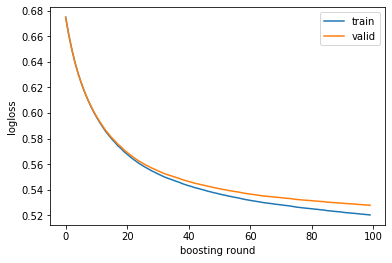

In [21]:
train_run = workflow.run(
    name = 'train_model',
    handler=train,
    inputs={
        'xtrain': split_run.output('xtrain'),
        'ytrain': split_run.output('ytrain'),
        'xvalid': split_run.output('xvalid'),
        'yvalid': split_run.output('yvalid')},
    params={
        'losses_target': '/User/projects/lightgbm/results',
        'losses_name': 'train_valid_losses.csv',
        'model_target': '/User/projects/lightgbm/models',
        'model_name': 'lightgbm.model.pickle'})

[mlrun] 2019-12-17 22:36:15,395 starting run test_model uid=f6c9852dab934ef3a636dd3b30e9a52f  -> /User/mlrun
[mlrun] 2019-12-17 22:36:15,659 test input 50000 rows
[mlrun] 2019-12-17 22:36:15,767 type: <class 'numpy.float64'>   value: 0.73248



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...e9a52f,0,Dec 17 22:36:15,completed,test_model,repo=https://github.com/yjb-ds/demos.gitcommit=25df19665dd27c0bd37f984b5c4adc57a6a51165kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-fr4p9,model_dirxtestytest,model_name=lightgbm.model.pickle,accuracy=0.73248,roc-curve.html


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid f6c9852dab934ef3a636dd3b30e9a52f 
[mlrun] 2019-12-17 22:36:15,903 run executed, status=completed


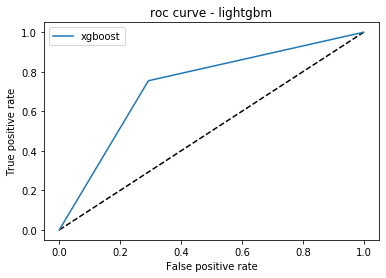

In [22]:
test_run = workflow.run(
    name = 'test_model',
    handler=test,
    inputs={
        'model_dir': train_run.output('model_dir'),
        'xtest': split_run.output('xtest'),
        'ytest': split_run.output('ytest')},
    params={
        'model_name': 'lightgbm.model.pickle'})

<a id="image"></a>
### Create a deployment image

Once debugged you can create a reusable image, and then deploy it for testing. In the following line we are converting the code block between the ```#nuclio: ignore``` and ```#nuclio: end-code``` to be run as a KubeJob.  Next we build an image named ```mlrun/mlrunlgb:latest```.  _**It is important to ensure that this image has been built at least once, and that you have access to it.**_

In [23]:
lgbm_job = code_to_function(runtime='job').apply(mount_v3io())

lgbm_job.build(image='mlrun/mlrunlgb:latest')

[mlrun] 2019-12-17 22:40:10,396 building image (mlrun/mlrunlgb:latest)
FROM python:3.6-jessie
WORKDIR /run
RUN pip install -U matplotlib seaborn sklearn lightgbm kfp joblib pyarrow
RUN pip install mlrun
ENV PYTHONPATH /run
[mlrun] 2019-12-17 22:40:10,399 using in-cluster config.
[mlrun] 2019-12-17 22:40:10,416 Pod mlrun-build-dkx8h created
..
INFO[0000] Resolved base name python:3.6-jessie to python:3.6-jessie 
INFO[0000] Resolved base name python:3.6-jessie to python:3.6-jessie 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Error while retrieving image from cache: getting file info: stat /cache/sha256:0318d80cb241983eda20b905d77fa0bfb06e29e5aabf075c7941ea687f1c125a: no such file or directory 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Error while retrieving image from cache: getting file info: stat /cache/sha256:0318d80cb24198

While debugging, and _**after you have run**_ ```build``` **_at least once**_, you can comment out the last cell so that the build process isn't started needlessly.  The code can be injected into the job using the following line:

In [ ]:
# lgbm_job.with_code()

<a id="pipeline"></a>
### Create a KubeFlow Pipeline from our functions

Our pipeline will consist of two instead of three steps, ```load``` and ```train```.  We'll drop the ```test```
here since at the end of this deployment we can test the system with API requests.

For complete details on KubeFlow Pipelines please refer to the following docs:
1. **[KubeFlow pipelines](https://www.kubeflow.org/docs/pipelines/)**.
2. **[kfp.dsl Python package](https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.dsl.html#module-kfp.dsl)**.

Please note, the model server file name in the ```new_model_server``` function call below should identical in every respect to the name of the model server notebook.

In [29]:
import kfp
from kfp import dsl

In [43]:
@dsl.pipeline(
    name='LGBMClassifier Training Pipeline - HIGGS',
    description='Shows how to use mlrun/kfp.'
)
def lgbm_pipeline(
   learning_rate = [0.1, 0.3], num_leaves = [31, 32]
):

    acquire_step = lgbm_job.as_step(
            name='acquire_remote_data',
            handler='acquire',
            params={
                'archive_url': "/User/projects/lightgbm/data/HIGGS.csv.gz",
                'name': 'original',
                'target_path': '/User/projects/lightgbm/data/raw'},
            outputs=['original'], 
            out_path='/User/projects/lightgbm/data/raw').apply(mount_v3io())
    
    split_step = lgbm_job.as_step(
            name='split_data',
            handler='split',
            params={
                'sample': -500_000,
                'target_path': '/User/projects/lightgbm/data/raw'},
            outputs=['xtrain', 'ytrain', 'xvalid', 'yvalid', 'xtest', 'ytest'], 
            out_path='/User/projects/lightgbm/data/raw').apply(mount_v3io())

    train_step = lgbm_job.as_step(
            name='train_model', 
            handler='train',
            params = {
                'losses_target': '/User/projects/lightgbm/results',
                'losses_name': 'train_valid_losses.csv',
                'model_target': '/User/projects/lightgbm/models',
                'model_name': 'lightgbm.model.pickle'
                },
            hyperparams = {
                'learning_rate': learning_rate,
                'num_leaves': num_leaves},
            selector='max.accuracy',
            inputs = {'xtrain': split_step.outputs['xtrain'],
                      'ytrain':split_step.outputs['ytrain'],
                      'xvalid':split_step.outputs['xvalid'],
                      'yvalid':split_step.outputs['yvalid']}, 
            outputs=['model_dir'],
            out_path= '/User/projects/lightgbm/models').apply(mount_v3io())

    test_step = lgbm_job.as_step(
        name='test_model',
        handler='test',
        inputs = {'model_dir': train_step.outputs['model_dir'],
                  'xtest': split_step.outputs['xtest'],
                  'ytest':split_step.outputs['ytest']}, 
        params = {
            'model_name': 'lightgbm.model.pickle'
        },
        out_path='/User/projects/lightgbm/results').apply(mount_v3io())

    importance_step = lgbm_job.as_step(
        name='importance_model',
        handler='importance',
        inputs = {'model_dir': train_step.outputs['model_dir'],
                  'xtest': split_step.outputs['xtest']},
        params = {
            'model_name': 'lightgbm.model.pickle'
        },
        out_path='/User/projects/lightgbm/results').apply(mount_v3io())

    # define a nuclio-serving function, generated from a notebook file
    srvfn = new_model_server(
        'higgs-serving', 
        model_class='LGBoostModel', 
        filename='model-server.ipynb')
    
    # deploy the model serving function with inputs from the training stage
    deploy = srvfn.with_v3io('User', '~/').deploy_step(project='refactor-demos', 
                                                       models={'lgbm_v5_joblib': train_step.outputs['model_dir']})

<a id="compile the pipeline"></a>
### compile the pipeline

We can compile our KubeFlow pipeline and produce a yaml description of the pipeline worflow:

In [44]:
makedirs('/User/projects/lightgbm/yaml', exist_ok=True)
kfp.compiler.Compiler().compile(lgbm_pipeline, '/User/projects/lightgbm/yaml/mlrunpipe.yaml')

/User/.pythonlibs/lib/python3.6/site-packages/kfp/components/_data_passing.py:133: UserWarning: Missing type name was inferred as "JsonArray" based on the value "[0.1, 0.3]".
  warnings.warn('Missing type name was inferred as "{}" based on the value "{}".'.format(type_name, str(value)))
/User/.pythonlibs/lib/python3.6/site-packages/kfp/components/_data_passing.py:133: UserWarning: Missing type name was inferred as "JsonArray" based on the value "[31, 32]".
  warnings.warn('Missing type name was inferred as "{}" based on the value "{}".'.format(type_name, str(value)))


In [45]:
client = kfp.Client(namespace='default-tenant')

In [46]:
arguments = {
    'learning_rate': [0.01, 0.1, 0.30],
    'num_leaves': [31, 255]}

run_result = client.create_run_from_pipeline_func(
    lgbm_pipeline, 
    arguments, 
    run_name='lgbm 8',
    experiment_name='lgbm_parquet')